In [1]:
import os
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

import pickle # saving and loading trained model
from os import path

# importing required libraries for normalizing data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# importing library for plotting
import matplotlib.pyplot as plt
import seaborn as sn

import glob
import random


from sklearn import metrics
from sklearn.metrics import accuracy_score # for calculating accuracy of model
from sklearn.model_selection import train_test_split # for splitting the dataset for training and testing
from sklearn.metrics import classification_report # for generating a classification report of model

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

from keras.layers import Dropout, Activation, Flatten, Convolution1D, Dropout, Reshape
from keras.layers import Dense # importing dense layer
from keras.models import Sequential #importing Sequential layer

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    print(gpu, "\n")
else:
  print("No GPU device found")

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') 



In [3]:
!nvidia-smi

Sat Mar 11 14:10:55 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 531.18                 Driver Version: 531.18       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti    WDDM | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8               12W / 200W|    837MiB /  8192MiB |      3%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
import glob

path = r'H:\Datasets\cic-ids-2018' # use your path
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, low_memory=False, index_col=None, header=0)
    li.append(df)
    print("Read Completed for ", filename)

df = pd.concat(li, axis=0, ignore_index=True)

df = df.rename(columns={'label': 'Label'})

Read Completed for  H:\Datasets\cic-ids-2018\bot_02-03-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\bruteforce-web-xss_sql-injection_22-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\bruteforce-web-xss_sql-injection_23-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\ddos-loic-udp_hoic_21-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\dos-goldeneye-slowloris_15-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\dos-slowhttp-hulk_16-02-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\infiltration_01-03-2018.csv
Read Completed for  H:\Datasets\cic-ids-2018\infiltration_28-02-2018.csv


In [5]:
df.describe()

,dst_port,protocol,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,...,fwd_act_data_pkts,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min
count,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,...,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06,7.235620e+06
mean,1.176293e+04,8.178602e+00,1.073036e+07,3.324145e+01,5.742645e+00,1.333921e+03,4.456568e+03,2.376153e+02,9.024902e+00,5.710277e+01,...,2.969893e+01,1.944764e+01,9.569520e+04,4.484061e+04,1.506702e+05,6.705993e+04,5.121205e+06,3.393498e+05,5.633248e+06,4.703578e+06
std,2.079196e+04,4.514253e+00,5.622927e+08,1.868033e+03,1.769811e+02,8.301538e+04,2.506477e+05,3.434789e+02,2.464588e+01,7.015623e+01,...,1.866864e+03,7.896557e+00,1.568348e+06,9.130883e+05,2.079168e+06,1.341667e+06,3.358656e+08,2.075285e+08,7.357827e+08,9.374236e+07
min,0.000000e+00,0.000000e+00,-8.282200e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.000000e+01,6.000000e+00,7.460000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,4.430000e+02,6.000000e+00,1.478900e+04,2.000000e+00,1.000000e+00,4.400000e+01,9.600000e+01,4.100000e+01,0.000000e+00,3.600000e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.080000e+03,6.000000e+00,3.452732e+06,5.000000e+00,4.000000e+00,6.750000e+02,3.550000e+02,3.870000e+02,0.000000e+00,1.027143e+02,...,1.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553500e+04,1.700000e+01,1.200000e+08,3.096290e+05,1.231180e+05,1.443918e+08,1.563604e+08,6.444000e+04,1.460000e+03,1.652931e+04,...,3.096280e+05,5.600000e+01,1.140000e+08,7.495336e+07,1.140000e+08,1.140000e+08,3.955714e+11,2.622479e+11,9.684340e+11,2.399340e+11


In [6]:
df.head()

,dst_port,protocol,timestamp,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,Label
0,443,6,02/03/2018 08:47:38,141385,9,7,553,3773.0,202,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
1,49684,6,02/03/2018 08:47:38,281,2,1,38,0.0,38,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
2,443,6,02/03/2018 08:47:40,279824,11,15,1086,10527.0,385,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
3,443,6,02/03/2018 08:47:40,132,2,0,0,0.0,0,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign
4,443,6,02/03/2018 08:47:41,274016,9,13,1285,6141.0,517,0,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Benign


In [7]:
df["Label"].value_counts()

Benign                      5444525
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection                    87
Name: Label, dtype: int64

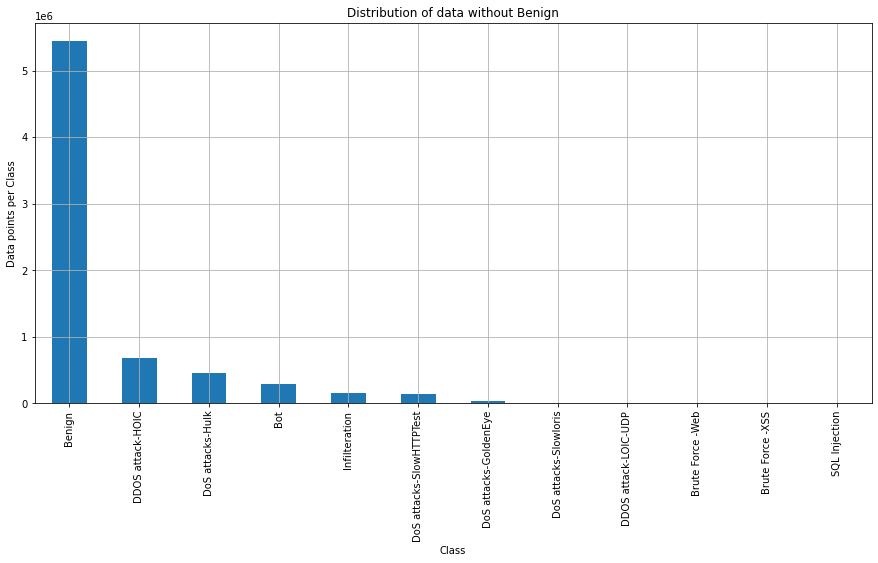

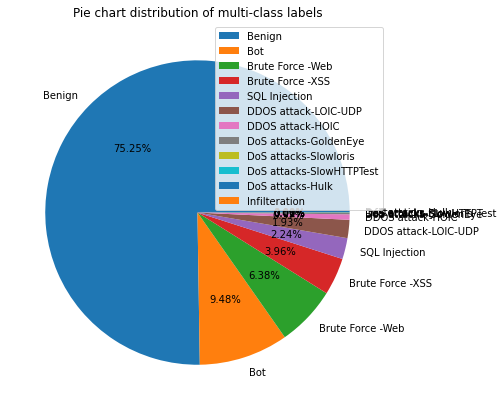

In [8]:
plt.figure(figsize=(15,7))
class_distribution = df[df["Label"] != "BENIGN"]["Label"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of data without Benign')
plt.grid()
plt.show()


# pie chart distribution of multi-class labels
plt.figure(figsize=(15,7))
plt.pie(df['Label'].value_counts(),labels=df['Label'].unique(),autopct='%0.2f%%')
plt.title('Pie chart distribution of multi-class labels')
plt.legend()
plt.savefig('Pie_chart_multi.png')
plt.show()

In [9]:
metadata = ['fl_dur' #Flow duration
,'tot_fw_pk' #Total packets in the forward direction
,'tot_bw_pk' #Total packets in the backward direction
,'tot_l_fw_pkt' #Total size of packet in forward direction
,'fw_pkt_l_max' #Maximum size of packet in forward direction
,'fw_pkt_l_min' #Minimum size of packet in forward direction
,'fw_pkt_l_avg' #Average size of packet in forward direction
,'fw_pkt_l_std' #Standard deviation size of packet in forward direction
,'Bw_pkt_l_max' #Maximum size of packet in backward direction
,'Bw_pkt_l_min' #Minimum size of packet in backward direction
,'Bw_pkt_l_avg' #Mean size of packet in backward direction
,'Bw_pkt_l_std' #Standard deviation size of packet in backward direction
,'fl_byt_s' #flow byte rate that is number of packets transferred per second
,'fl_pkt_s' #flow packets rate that is number of packets transferred per second
,'fl_iat_avg' #Average time between two flows
,'fl_iat_std' #Standard deviation time two flows
,'fl_iat_max' #Maximum time between two flows
,'fl_iat_min' #Minimum time between two flows
,'fw_iat_tot' #Total time between two packets sent in the forward direction
,'fw_iat_avg' #Mean time between two packets sent in the forward direction
,'fw_iat_std' #Standard deviation time between two packets sent in the forward direction
,'fw_iat_max' #Maximum time between two packets sent in the forward direction
,'fw_iat_min' #Minimum time between two packets sent in the forward direction
,'bw_iat_tot' #Total time between two packets sent in the backward direction
,'bw_iat_avg' #Mean time between two packets sent in the backward direction
,'bw_iat_std' #Standard deviation time between two packets sent in the backward direction
,'bw_iat_max' #Maximum time between two packets sent in the backward direction
,'bw_iat_min' #Minimum time between two packets sent in the backward direction
,'fw_psh_flag' #Number of times the PSH flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_psh_flag' #Number of times the PSH flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_urg_flag' #Number of times the URG flag was set in packets travelling in the forward direction (0 for UDP)
,'bw_urg_flag' #Number of times the URG flag was set in packets travelling in the backward direction (0 for UDP)
,'fw_hdr_len' #Total bytes used for headers in the forward direction
,'bw_hdr_len' #Total bytes used for headers in the forward direction
,'fw_pkt_s' #Number of forward packets per second
,'bw_pkt_s' #Number of backward packets per second
,'pkt_len_min' #Minimum length of a flow
,'pkt_len_max' #Maximum length of a flow
,'pkt_len_avg' #Mean length of a flow
,'pkt_len_std' #Standard deviation length of a flow
,'pkt_len_va' #Minimum inter-arrival time of packet
,'fin_cnt' #Number of packets with FIN
,'syn_cnt' #Number of packets with SYN
,'rst_cnt' #Number of packets with RST
,'pst_cnt' #Number of packets with PUSH
,'ack_cnt' #Number of packets with ACK
,'urg_cnt' #Number of packets with URG
,'cwe_cnt' #Number of packets with CWE
,'ece_cnt' #Number of packets with ECE
,'down_up_ratio' #Download and upload ratio
,'pkt_size_avg' #Average size of packet
,'fw_seg_avg' #Average size observed in the forward direction
,'bw_seg_avg' #Average size observed in the backward direction
,'fw_byt_blk_avg' #Average number of bytes bulk rate in the forward direction
,'fw_pkt_blk_avg' #Average number of packets bulk rate in the forward direction
,'fw_blk_rate_avg' #Average number of bulk rate in the forward direction
,'bw_byt_blk_avg' #Average number of bytes bulk rate in the backward direction
,'bw_pkt_blk_avg' #Average number of packets bulk rate in the backward direction
,'bw_blk_rate_avg' #Average number of bulk rate in the backward direction
,'subfl_fw_pk' #The average number of packets in a sub flow in the forward direction
,'subfl_fw_byt' #The average number of bytes in a sub flow in the forward direction
,'subfl_bw_pkt' #The average number of packets in a sub flow in the backward direction
,'subfl_bw_byt' #The average number of bytes in a sub flow in the backward direction
,'fw_win_byt' #Number of bytes sent in initial window in the forward direction
,'bw_win_byt' ## of bytes sent in initial window in the backward direction
,'Fw_act_pkt' ## of packets with at least 1 byte of TCP data payload in the forward direction
,'fw_seg_min' #Minimum segment size observed in the forward direction
,'atv_avg' #Mean time a flow was active before becoming idle
,'atv_std' #Standard deviation time a flow was active before becoming idle
,'atv_max' #Maximum time a flow was active before becoming idle
,'atv_min' #Minimum time a flow was active before becoming idle
,'idl_avg' #Mean time a flow was idle before becoming active
,'idl_std' #Standard deviation time a flow was idle before becoming active
,'idl_max' #Maximum time a flow was idle before becoming active
,'idl_min' #Minimum time a flow was idle before becoming active
]

In [10]:
features = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [11]:
# Remove columns with only values of 0
useless_columns = ['dst_port', 'protocol', 'timestamp']
df.drop(labels=useless_columns, axis='columns', inplace=True)
print('After dropping some columns: \n\t there are {} columns and {} rows'.format(len(df.columns), len(df)))

features = df.columns

After dropping some columns: 
	 there are 77 columns and 7235620 rows


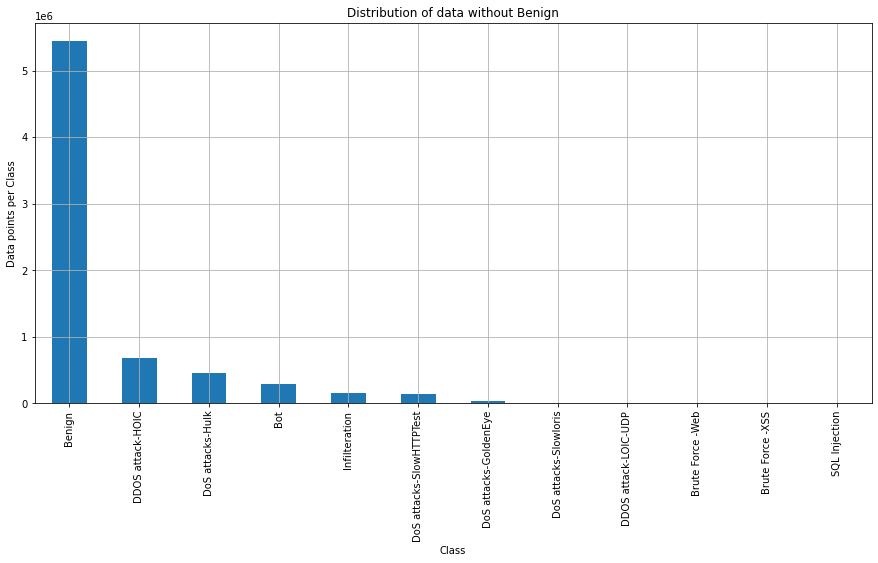

In [12]:
plt.figure(figsize=(15,7))
class_distribution = df[df["Label"] != "BENIGN"]["Label"].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of data without Benign')
plt.grid()
plt.show()

In [13]:
from scipy.stats import zscore

def expand_categories(values):
    result = []
    s = values.value_counts()
    t = float(len(values))
    for v in s.index:
        result.append("{}:{}%".format(v,round(100*(s[v]/t),2)))
    return "[{}]".format(",".join(result))
        
def analyze(df):
    print()
    cols = df.columns.values
    total = float(len(df))

    print("{} rows".format(int(total)))
    for col in cols:
        uniques = df[col].unique()
        unique_count = len(uniques)
        if unique_count>100:
            print("** {}:{} ({}%)".format(col,unique_count,int(((unique_count)/total)*100)))
        else:
            print("** {}:{}".format(col,expand_categories(df[col])))
            expand_categories(df[col])

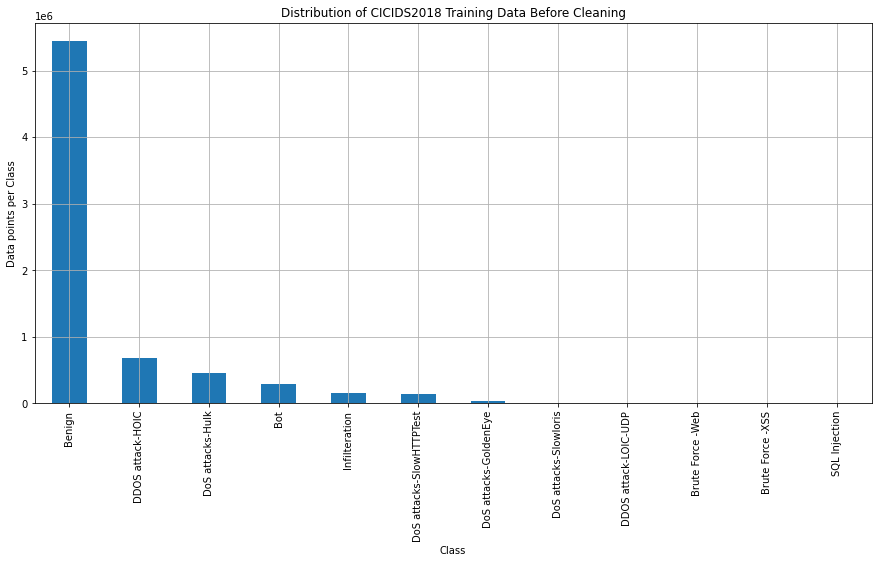

In [14]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import *

plt.figure(figsize=(15,7))
class_distribution = df['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of CICIDS2018 Training Data Before Cleaning')
plt.grid()
plt.show()

In [15]:
# Before Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class Benign : 5444525 ( 75.246 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.481 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.384 %)
Number of data points in class Bot : 286191 ( 3.955 %)
Number of data points in class Infilteration : 161934 ( 2.238 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.933 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.574 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [16]:
#drop na values and reset index
data_clean = df.dropna().reset_index()

# Checkng for DUPLICATE values
data_clean.drop_duplicates(keep='first', inplace = True)

data_clean['Label'].value_counts()

print("Read {} rows.".format(len(data_clean)))

Read 7214943 rows.


In [17]:
analyze(data_clean)


7214943 rows
** index:7214943 (100%)
** flow_duration:2276311 (31%)
** tot_fwd_pkts:3534 (0%)
** tot_bwd_pkts:2527 (0%)
** totlen_fwd_pkts:15086 (0%)
** totlen_bwd_pkts:55856 (0%)
** fwd_pkt_len_max:1495 (0%)
** fwd_pkt_len_min:378 (0%)
** fwd_pkt_len_mean:74876 (1%)
** fwd_pkt_len_std:172162 (2%)
** bwd_pkt_len_max:1453 (0%)
** bwd_pkt_len_min:377 (0%)
** bwd_pkt_len_mean:127820 (1%)
** bwd_pkt_len_std:185297 (2%)
** flow_byts_s:3088543 (42%)
** flow_pkts_s:2753137 (38%)
** flow_iat_mean:2574633 (35%)
** flow_iat_std:3267832 (45%)
** flow_iat_max:1530887 (21%)
** flow_iat_min:417527 (5%)
** fwd_iat_tot:1970492 (27%)
** fwd_iat_mean:2296965 (31%)
** fwd_iat_std:2446852 (33%)
** fwd_iat_max:1575653 (21%)
** fwd_iat_min:502936 (6%)
** bwd_iat_tot:1398003 (19%)
** bwd_iat_mean:1678410 (23%)
** bwd_iat_std:2081006 (28%)
** bwd_iat_max:903930 (12%)
** bwd_iat_min:317698 (4%)
** fwd_psh_flags:[0:96.84%,1:3.16%]
** bwd_psh_flags:[0:100.0%]
** fwd_urg_flags:[0:99.96%,1:0.04%]
** bwd_urg_flags

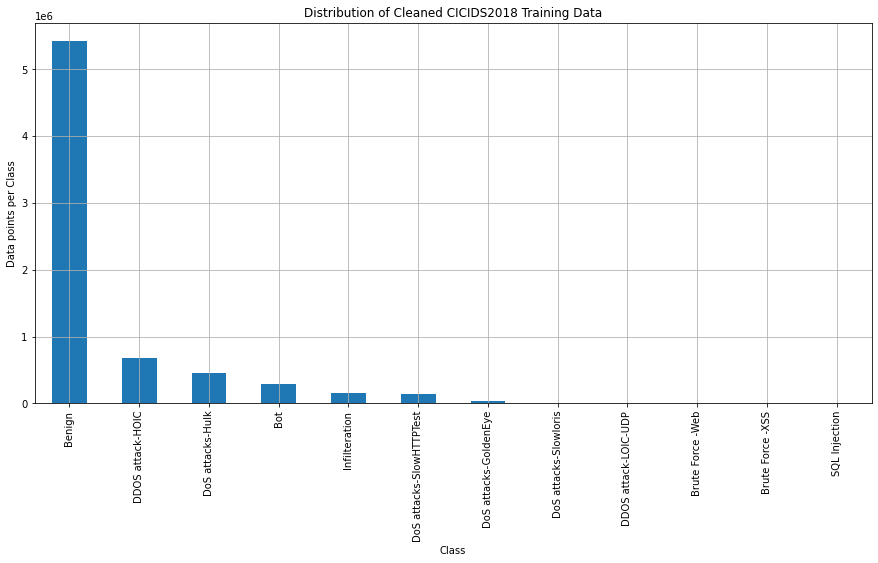

In [18]:
plt.figure(figsize=(15,7))
class_distribution = data_clean['Label'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Class')
plt.ylabel('Data points per Class')
plt.title('Distribution of Cleaned CICIDS2018 Training Data')
plt.grid()
plt.show()

In [19]:
# After Cleaning Data set for Duplicate
sorted_ds = np.argsort(-class_distribution.values)
for i in sorted_ds:
    print('Number of data points in class', class_distribution.index[i],':', class_distribution.values[i], 
          '(', np.round((class_distribution.values[i]/df.shape[0]*100), 3), '%)')

Number of data points in class Benign : 5424686 ( 74.972 %)
Number of data points in class DDOS attack-HOIC : 686012 ( 9.481 %)
Number of data points in class DoS attacks-Hulk : 461912 ( 6.384 %)
Number of data points in class Bot : 286191 ( 3.955 %)
Number of data points in class Infilteration : 161096 ( 2.226 %)
Number of data points in class DoS attacks-SlowHTTPTest : 139890 ( 1.933 %)
Number of data points in class DoS attacks-GoldenEye : 41508 ( 0.574 %)
Number of data points in class DoS attacks-Slowloris : 10990 ( 0.152 %)
Number of data points in class DDOS attack-LOIC-UDP : 1730 ( 0.024 %)
Number of data points in class Brute Force -Web : 611 ( 0.008 %)
Number of data points in class Brute Force -XSS : 230 ( 0.003 %)
Number of data points in class SQL Injection : 87 ( 0.001 %)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder


#drop na values and reset index
data_clean = df.dropna().reset_index()

# label encoding
labelencoder = LabelEncoder()
data_clean['Label'] = labelencoder.fit_transform(data_clean['Label'])

data_clean['Label'].value_counts()

data_np = data_clean.to_numpy(dtype="float32")
data_np = data_np[~np.isinf(data_np).any(axis=1)]

#del df

X = data_np[:, 0:76]

enc = OneHotEncoder()

Y = enc.fit_transform(data_np[:,77:]).toarray()

In [21]:
data_clean.shape

(7214943, 78)

In [22]:
data_clean.columns

Index(['index', 'flow_duration', 'tot_fwd_pkts', 'tot_bwd_pkts',
       'totlen_fwd_pkts', 'totlen_bwd_pkts', 'fwd_pkt_len_max',
       'fwd_pkt_len_min', 'fwd_pkt_len_mean', 'fwd_pkt_len_std',
       'bwd_pkt_len_max', 'bwd_pkt_len_min', 'bwd_pkt_len_mean',
       'bwd_pkt_len_std', 'flow_byts_s', 'flow_pkts_s', 'flow_iat_mean',
       'flow_iat_std', 'flow_iat_max', 'flow_iat_min', 'fwd_iat_tot',
       'fwd_iat_mean', 'fwd_iat_std', 'fwd_iat_max', 'fwd_iat_min',
       'bwd_iat_tot', 'bwd_iat_mean', 'bwd_iat_std', 'bwd_iat_max',
       'bwd_iat_min', 'fwd_psh_flags', 'bwd_psh_flags', 'fwd_urg_flags',
       'bwd_urg_flags', 'fwd_header_len', 'bwd_header_len', 'fwd_pkts_s',
       'bwd_pkts_s', 'pkt_len_min', 'pkt_len_max', 'pkt_len_mean',
       'pkt_len_std', 'pkt_len_var', 'fin_flag_cnt', 'syn_flag_cnt',
       'rst_flag_cnt', 'psh_flag_cnt', 'ack_flag_cnt', 'urg_flag_cnt',
       'cwe_flag_count', 'ece_flag_cnt', 'down_up_ratio', 'pkt_size_avg',
       'fwd_seg_size_avg', 'bwd_se

In [23]:
data_clean.head()

,index,flow_duration,tot_fwd_pkts,tot_bwd_pkts,totlen_fwd_pkts,totlen_bwd_pkts,fwd_pkt_len_max,fwd_pkt_len_min,fwd_pkt_len_mean,fwd_pkt_len_std,...,fwd_seg_size_min,active_mean,active_std,active_max,active_min,idle_mean,idle_std,idle_max,idle_min,Label
0,0,141385,9,7,553,3773.0,202,0,61.444444,87.534438,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,281,2,1,38,0.0,38,0,19.000000,26.870058,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,2,279824,11,15,1086,10527.0,385,0,98.727273,129.392497,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3,132,2,0,0,0.0,0,0,0.000000,0.000000,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,4,274016,9,13,1285,6141.0,517,0,142.777778,183.887722,...,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data set into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.25, random_state=2, shuffle=True)

_features = X.shape[1]
n_classes = Y.shape[1]

# DNN

In [25]:
model = Sequential()

model.add(Dense(128, input_dim=_features, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_classes, kernel_initializer='normal'))
model.add(Dense(n_classes,activation='softmax'))
#model.add(Activation('softmax'))
model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='BinaryCrossentropy', optimizer=opt, metrics=['accuracy'])

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #,callbacks=[reduce_lr, early_stop_callback]
                              validation_data=(X_test, Y_test))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               9856      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 12)                1

In [26]:
import time

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 44s 776us/step
Inference time: 73.14 seconds


In [27]:
pred.shape
y_test.shape

(1800785,)

In [28]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1349127,     130,       2,       0,       5,       0,      10,
            418,       5,      10,    2606,       0],
       [     18,   72048,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     79,       0,      64,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     24,       0,       0,      28,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,  171772,       0,       0,
              0,       0,       0,       0,       0],
       [      3,       0,       0,       0,       0,     461,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,   10415,
              0,       0,       3,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
         115548,       0,       0,       0,       0],


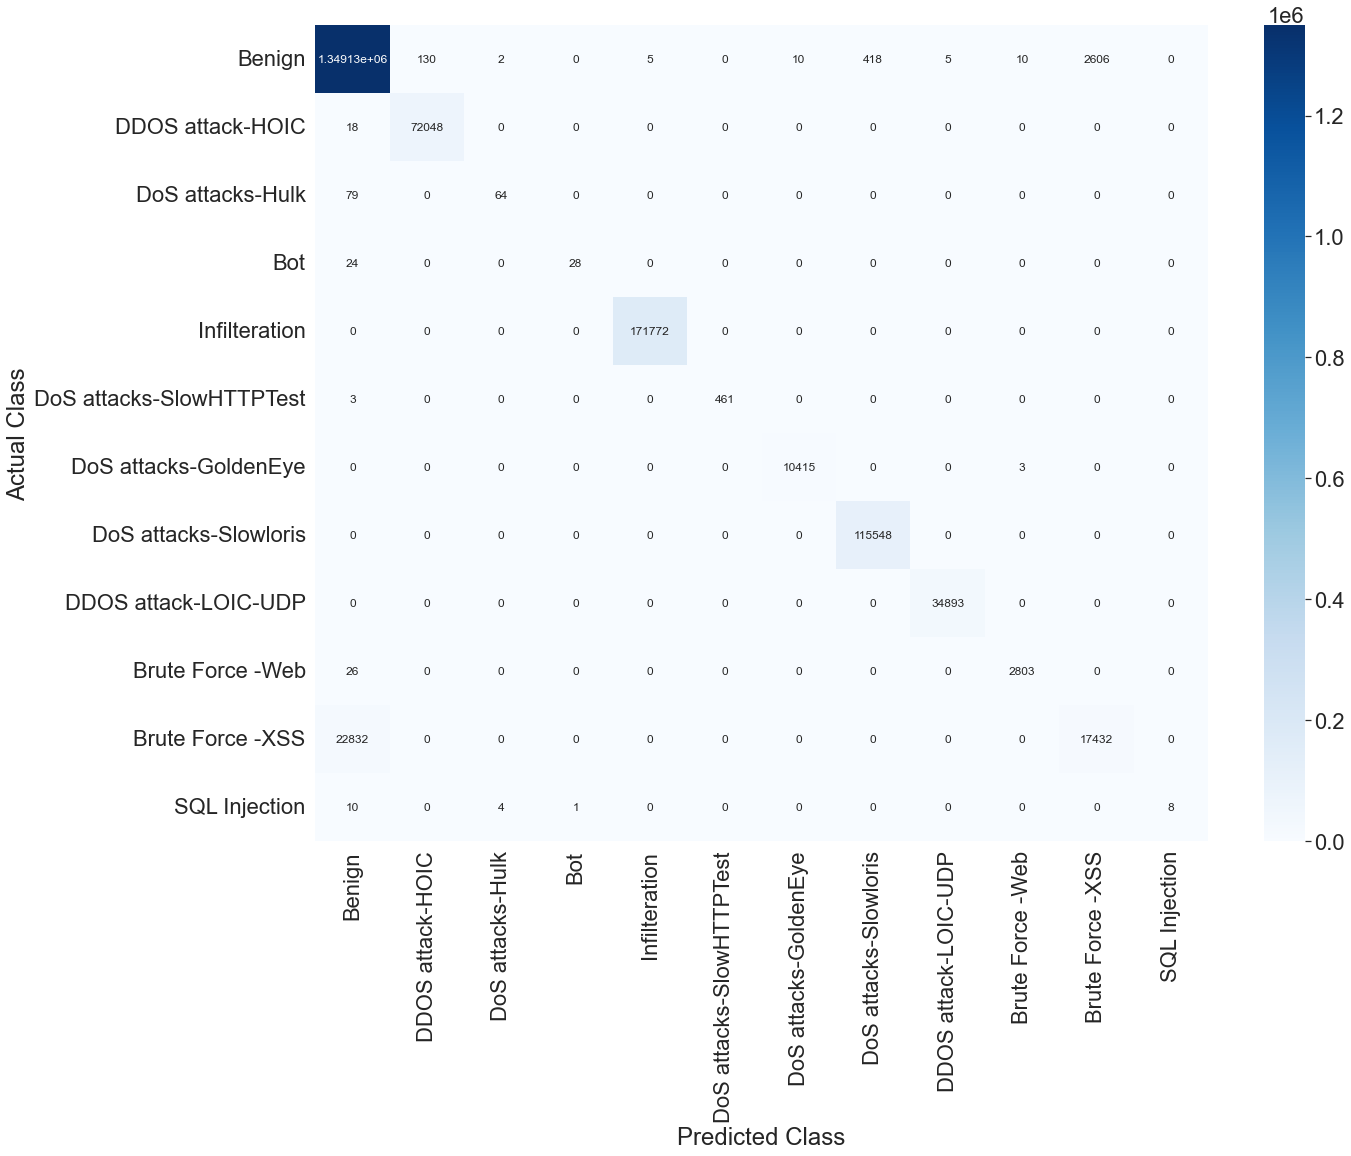

In [29]:
#cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(confMat)

labels = ['Benign','DDOS attack-HOIC','DoS attacks-Hulk','Bot','Infilteration','DoS attacks-SlowHTTPTest',
          'DoS attacks-GoldenEye','DoS attacks-Slowloris','DDOS attack-LOIC-UDP','Brute Force -Web','Brute Force -XSS',
          'SQL Injection']

plt.figure(figsize=(20,15))
sn.set(font_scale=2)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 

In [30]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))


pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 44s 775us/step
Inference time: 59.30 seconds
Completed
Time taken: 0:02:22.682691
Validation score: 0.9854585639040752
Evaluation score: [0.010651777498424053, 0.9854585528373718]
Recall score: 0.9854585639040752
Precision score: 0.9841791420332472
F1 Measure score: 0.9831305209425663
ROC-AUC score: 0.9039641421423975


# CNN

In [31]:
# In order to ignore FutureWarning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

from keras.models import Sequential
from keras import callbacks
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from sklearn import metrics




K = keras.backend

X_train = X_train.reshape(X_train.shape[0], 76, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 76, 1).astype('float32')

In [32]:
# CNN Model
model = Sequential()
model.add(Convolution1D(filters=128, kernel_size=6, input_shape=(_features, 1)))
model.add(Activation('relu'))
model.add(Convolution1D(filters=256, kernel_size=6))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(n_classes))
model.add(Activation('softmax'))
model.summary() 

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

early_stop_callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                  patience=3, min_lr=0.0001)
    
history = model.fit(X_train, Y_train,
                              batch_size=128,
                              epochs=30,
                              verbose=True, #callbacks=[reduce_lr, early_stop_callback],
                              validation_data=(X_test, Y_test)) 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 71, 128)           896       
                                                                 
 activation (Activation)     (None, 71, 128)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 66, 256)           196864    
                                                                 
 activation_1 (Activation)   (None, 66, 256)           0         
                                                                 
 flatten (Flatten)           (None, 16896)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               4325632   
                                                                 
 dropout_3 (Dropout)         (None, 256)              

In [33]:
#y_pred = model.predict_classes(X_test)
y_pred = np.argmax(model.predict(X_test), axis=-1)
balanced_score = metrics.balanced_accuracy_score(np.argmax(Y_test, axis=1), y_pred) * 100
    
best_loss = np.amin(history.history['val_loss']) 
print('Best loss: {}'.format(best_loss))
print('Balanced Acc loss: {}'.format(balanced_score))
    
    
import tensorflow.keras.backend as K
print('Learning Rate - ')
print(K.eval(model.optimizer.lr)) 
print('==================================')

model.save('H:/Datasets/CIC-IDS2018/model_cnn.h5')

56275/56275 [==============================] - 47s 841us/step
Best loss: 0.024503985419869423
Balanced Acc loss: 86.25099704181272
Learning Rate - 
1e-04


In [34]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import preprocessing
import time

start = dt.datetime.now()

escore = model.evaluate(X_test, Y_test, batch_size=32)

# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)

score = metrics.accuracy_score(y_eval, pred)
rscore = recall_score(y_eval, pred, average='weighted')
ascore = precision_score(y_eval, pred, average='weighted')
f1score= f1_score(y_eval, pred, average='weighted') #F1 = 2 * (precision * recall) / (precision + recall) for manual

lb = preprocessing.LabelBinarizer()
lb.fit(y_eval)
y_eval = lb.transform(y_eval)
pred = lb.transform(pred)
roc_score = roc_auc_score(y_eval, pred)
#roc_auc_socre = multiclass_roc_auc_score(y_eval, pred)

print('Completed')
print('Time taken:',dt.datetime.now()-start)

print("Validation score: {}".format(score))
print("Evaluation score: {}".format(escore))
print("Recall score: {}".format(rscore))
print("Precision score: {}".format(ascore))
print("F1 Measure score: {}".format(f1score))
print("ROC-AUC score: {}".format(roc_score))

56275/56275 [==============================] - 47s 843us/step
Inference time: 62.55 seconds
Completed
Time taken: 0:02:46.290876
Validation score: 0.9897544681902615
Evaluation score: [0.02450343780219555, 0.9897544384002686]
Recall score: 0.9897544681902615
Precision score: 0.989447449492089
F1 Measure score: 0.9886083142276134
ROC-AUC score: 0.9296616107618948


In [35]:
# Measure inference time
start_time = time.time()
pred = model.predict(X_test)
end_time = time.time()

inference_time = end_time - start_time
print("Inference time: {:.2f} seconds".format(inference_time))

pred = np.argmax(pred,axis=1)
y_test = Y_test.argmax(axis=1)

56275/56275 [==============================] - 50s 882us/step
Inference time: 64.82 seconds


In [36]:
pred.shape
y_test.shape

(1800785,)

In [37]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import seaborn as sn

confMat = confusion_matrix(y_test, pred)
confMat

array([[1350593,      72,      17,       1,       3,       0,       2,
            429,       4,       5,    1187,       0],
       [     23,   72043,       0,       0,       0,       0,       0,
              0,       0,       0,       0,       0],
       [     40,       0,     102,       1,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      2,       0,      20,      30,       0,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,  171772,       0,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,     464,       0,
              0,       0,       0,       0,       0],
       [      0,       0,       0,       0,       0,       0,   10417,
              0,       0,       1,       0,       0],
       [      0,       0,       0,       0,       0,       0,       0,
         115548,       0,       0,       0,       0],


In [ ]:
#cf_matrix = confusion_matrix(y_test, pred)
cm_df = pd.DataFrame(confMat)

labels = ['Benign','DDOS attack-HOIC','DoS attacks-Hulk','Bot','Infilteration','DoS attacks-SlowHTTPTest',
          'DoS attacks-GoldenEye','DoS attacks-Slowloris','DDOS attack-LOIC-UDP','Brute Force -Web','Brute Force -XSS',
          'SQL Injection']

plt.figure(figsize=(20,15))
sn.set(font_scale=1.4)
sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels, cmap='Blues')

#sn.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
    
plt.show() 